In [14]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, fbeta_score, mean_squared_error, accuracy_score, roc_auc_score,recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, KFold, StratifiedKFold
import xgboost
import time

In [5]:
npzfile = np.load('df_tree.npz', allow_pickle=True)
df = pd.DataFrame(npzfile['data'], columns=npzfile['columns'])

In [6]:
X = df.drop(['return_target'], axis=1)
y = df['return_target']
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42,stratify=y)

In [10]:
def rf_model(X_other,y_other, X_test, y_test, random_state,verbose=1):
    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    n_splits = 5
    this_cv = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=random_state) # 分层？
    y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
    
    # find the best parameter set
    param_grid = {'n_estimators': [50, 100, 300, 500], 'max_features': ['log2', 'sqrt'],'max_depth': [2,4,8,16,32, 64, 128, 256]}

    pg = ParameterGrid(param_grid)

    scores = np.zeros((len(pg),n_splits))

    for i in range(len(pg)):
        if verbose >= 5:
                print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        for j, (train_index, val_index) in enumerate(this_cv.split(X_other,y_other)):
            X_train = X_other.iloc[train_index,:]
            y_train = y_other[train_index]
            X_val = X_other.iloc[val_index,:]
            y_val = y_other[val_index]
            clf.set_params(**params)
            clf.fit(X_train, y_train)# with early stopping
            y_val_pred = clf.predict(X_val)
            scores[i,j] = accuracy_score(y_val,y_val_pred)
            #scores[i,j] = recall_score(y_val,y_val_pred)
    scores = np.mean(scores, axis=1)
    #print(scores)
    print(np.max(scores))

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    clf.set_params(**best_params[0])
    clf.fit(X_train,y_train)
    y_test_pred = clf.predict(X_test)

    if verbose >= 1:
        print ('The accuracy is:',accuracy_score(y_test,y_test_pred))
        #print ('The recall is:',recall_score(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(clf.feature_importances_)

    test_score = accuracy_score(y_test,y_test_pred)

    return (test_score,y_test_pred,best_params, clf.feature_importances_)

# def dt_model(X_other, y_other, X_test, y_test, random_state, verbose=1):
#     n_splits = 10
#     this_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
#     y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

#     clf = DecisionTreeClassifier(random_state=random_state)
    
#     # 参数网格可以根据需求扩展
#     param_grid = {
#         'max_depth': [2, 4, 8, 16, 32,64,128,256],
#         'max_features': ['sqrt', 'log2', None]
#     }

#     pg = ParameterGrid(param_grid)
#     scores = np.zeros((len(pg), n_splits))

#     for i in range(len(pg)):
#         if verbose >= 5:
#             print(f"Param set {i + 1} / {len(pg)}")
#         params = pg[i]
#         for j, (train_index, val_index) in enumerate(this_cv.split(X_other, y_other)):
#             X_train = X_other.iloc[train_index, :]
#             y_train = y_other[train_index]
#             X_val = X_other.iloc[val_index, :]
#             y_val = y_other[val_index]
#             clf.set_params(**params)
#             clf.fit(X_train, y_train)
#             y_val_pred = clf.predict(X_val)
#             scores[i, j] = accuracy_score(y_val, y_val_pred)

#     scores = np.mean(scores, axis=1)
#     best_params = np.array(pg)[scores == np.max(scores)]

#     if verbose >= 4:
#         print('Test set max score and best parameters are:')
#         print(np.max(scores))
#         print(best_params)

#     clf.set_params(**best_params[0])
#     clf.fit(X_train, y_train)
#     y_test_pred = clf.predict(X_test)

#     if verbose >= 1:
#         print('The accuracy is:', accuracy_score(y_test, y_test_pred))
#     if verbose >= 2:
#         print('The predictions are:')
#         print(y_test_pred)
#     if verbose >= 3:
#         print("Feature importances:")
#         print(clf.feature_importances_)

#     return accuracy_score(y_test, y_test_pred), y_test_pred, best_params, clf.feature_importances_




In [11]:
pd.set_option('display.max_rows', None)
df.max(axis=0).to_frame()

,0
masked_bank_num,7
masked_account_type,4
masked_product_code,23
number_of_owners,8
total_deposit_amount,2800000.0
item_amt,2800000.0
relationship_balance,2745575018
rdis,2760.0
max_deposit_amount30d,3905799.42
total_deposit_item_count,907


In [12]:
for random_state in range(0,3):
        X_other,  X_test, y_other, y_test = train_test_split(X,y,train_size=0.2,random_state=random_state, shuffle=True,stratify=y)
        le = LabelEncoder() 
        y_other = le.fit_transform(y_other)
        y_test = le.transform(y_test)
        total_acc, y_pred, best_params, importance =  rf_model(pd.DataFrame(X_other),pd.DataFrame(y_other), pd.DataFrame(X_test), pd.DataFrame(y_test),random_state, verbose=1)

0.6878683068877398
The accuracy is: 0.6718266253869969
0.6780202452407836
The accuracy is: 0.6776667604840979
0.6802741625562092
The accuracy is: 0.674992963692654


In [15]:
print("\n===== Evaluation on test Set =====")
print(f"Accuracy : {accuracy_score(y_pred, y_test):.4f}")
print(f"Precision: {precision_score(y_pred, y_test):.4f}")
print(f"Recall   : {recall_score(y_pred, y_test):.4f}")
print(f"F1-score : {f1_score(y_pred, y_test):.4f}")
print(f"AUC      : {roc_auc_score(y_pred, y_test):.4f}")


===== Evaluation on test Set =====
Accuracy : 0.6750
Precision: 0.1174
Recall   : 0.5688
F1-score : 0.1946
AUC      : 0.6258


In [16]:
df.columns

Index(['masked_bank_num', 'masked_account_type', 'masked_product_code',
       'number_of_owners', 'total_deposit_amount', 'item_amt',
       'relationship_balance', 'rdis', 'max_deposit_amount30d',
       'total_deposit_item_count', 'prevtran1', 'prevtran2', 'prevtran3',
       'prevtran4', 'prevtran5', 'prevtran6', 'prevtran7', 'prevtran8',
       'prevtran9', 'prevtran10', 'drawee_sum', 'drawee_cnt', 'return_target',
       'month_num', 'fe_deposit_quarter', 'fe_deposit_week',
       'fe_amt_ratio_to_total', 'fe_amt_ratio_to_balance',
       'fe_total_amt_ratio_to_balance', 'fe_amt_change_from_prev',
       'fe_high_amt_flag', 'fe_max30d_ratio_total', 'fe_days_since_open',
       'fe_oao_flg', 'fe_onus_ind', 'fe_treasury_check_ind', 'fe_heloc_ind'],
      dtype='object')

In [18]:
importance,df.columns

(array([9.29275952e-03, 6.15007164e-03, 2.06550334e-02, 1.31641984e-02,
        5.61475683e-02, 6.55129689e-02, 5.29063721e-02, 3.90743487e-02,
        3.36104211e-02, 1.46967931e-02, 3.60598712e-02, 3.41365610e-02,
        3.05776047e-02, 2.31861826e-02, 2.29644234e-02, 2.17114649e-02,
        1.87849436e-02, 1.77589381e-02, 1.98858745e-02, 1.84845208e-02,
        4.42707222e-02, 4.73501975e-02, 1.74334826e-02, 7.52420632e-03,
        3.61295971e-02, 5.49602619e-02, 5.37179941e-02, 5.08266347e-02,
        7.09980425e-02, 4.11795285e-03, 3.26899232e-02, 1.40150717e-02,
        1.25137326e-03, 9.32310353e-03, 5.41061911e-04, 8.94545186e-05]),
 Index(['masked_bank_num', 'masked_account_type', 'masked_product_code',
        'number_of_owners', 'total_deposit_amount', 'item_amt',
        'relationship_balance', 'rdis', 'max_deposit_amount30d',
        'total_deposit_item_count', 'prevtran1', 'prevtran2', 'prevtran3',
        'prevtran4', 'prevtran5', 'prevtran6', 'prevtran7', 'prevtran8',


In [19]:
len(X.columns), len(importance)

(36, 36)

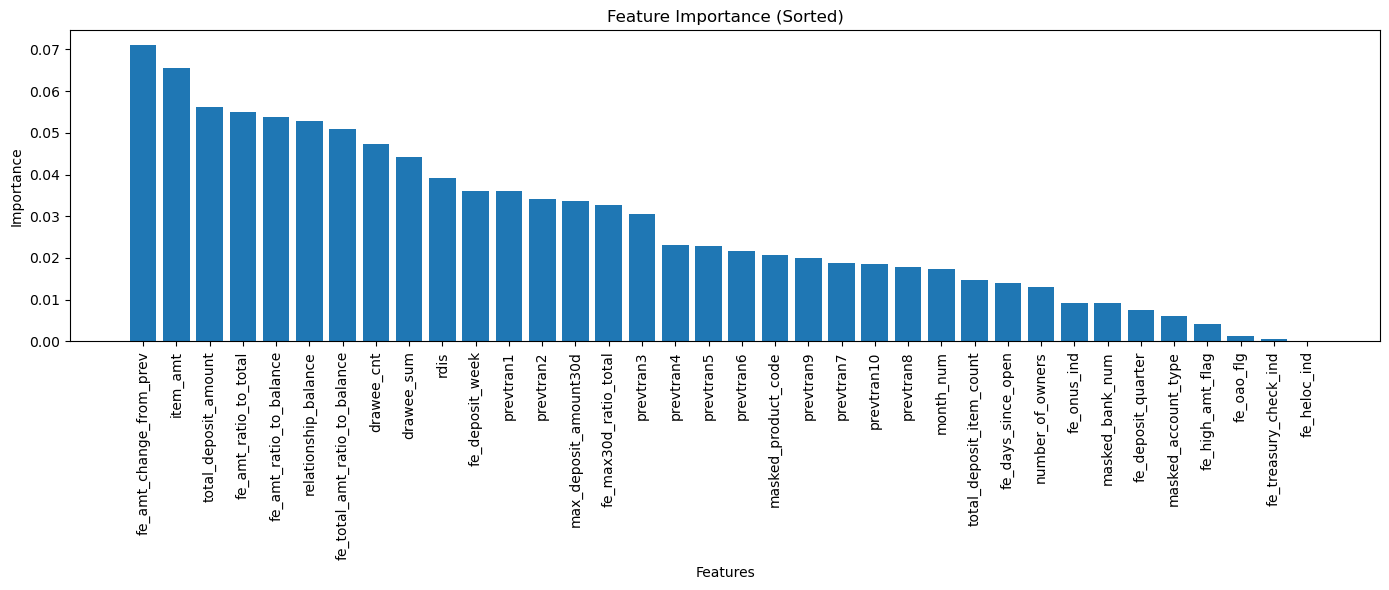

In [20]:
features = list(X.columns)

# 构建 DataFrame
importance_df = pd.DataFrame({
    "feature": features,
    "importance": importance
})

# 按照 importance 降序排序
importance_df = importance_df.sort_values(by="importance", ascending=False)

# 绘制直方图
plt.figure(figsize=(14, 6))
plt.bar(importance_df["feature"], importance_df["importance"])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Sorted)")
plt.tight_layout()
plt.show()
